In [3]:
import cv2
import numpy as np
import torch
from datetime import datetime
import matplotlib.pyplot as plt

image_path = "./data/sample.jpg"

### YOLO


0: 640x416 1 person, 38.4ms
Speed: 2.7ms preprocess, 38.4ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 416)


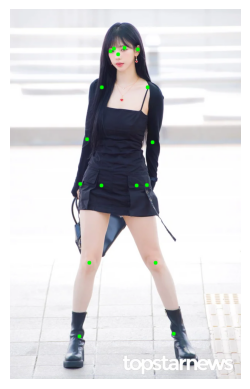

ÏÜåÏöîÏãúÍ∞Ñ: 0:00:00.352071


In [16]:
from ultralytics import YOLO

# üìå YOLO-Pose Î™®Îç∏ Î°úÎìú
yolo_model = YOLO("yolov8n-pose.pt")

# üìå Ïù¥ÎØ∏ÏßÄ Î°úÎìú
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

start = datetime.now()  ### ÏÜçÎèÑ ÌôïÏù∏ ###

# üìå YOLO-Pose Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ìè¨Ï¶à Í∞êÏßÄ
results = yolo_model(image)

# üìå Í¥ÄÏ†à(Keypoints) Ï¢åÌëú Ï∂îÏ∂ú Î∞è ÏãúÍ∞ÅÌôî
for result in results:
    keypoints = result.keypoints.xy.cpu().numpy()  # Ï¢åÌëú Î≥ÄÌôò
    scores = result.keypoints.conf.cpu().numpy()  # Ïã†Î¢∞ÎèÑ Î≥ÄÌôò

    for kp, score in zip(keypoints[0], scores[0]):
        if score > 0.5:  # Ïã†Î¢∞ÎèÑ 50% Ïù¥ÏÉÅ
            x, y = int(kp[0]), int(kp[1])
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # ÎÖπÏÉâ Ï†êÏúºÎ°ú ÌëúÏãú

# üìå ÏãúÍ∞ÅÌôîÎêú Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("ÏÜåÏöîÏãúÍ∞Ñ:", datetime.now() - start)  ### ÏÜçÎèÑ ÌôïÏù∏ ###


### OpenPose - Î≥¥Î•ò
- openposeÎäî ÏùºÎ∞òÏ†ÅÏù∏ pip installÎ°ú ÏÑ§ÏπòÌï† Ïàò ÏûàÎäî Ìå®ÌÇ§ÏßÄÍ∞Ä ÏïÑÎãò
- OpenPoseÎäî C++ Í∏∞Î∞òÏúºÎ°ú ÏûëÏÑ±ÎêòÏñ¥ ÏûàÏúºÎ©∞, ÏßÅÏ†ë ÎπåÎìú ÌõÑ Python APIÎ•º ÏÇ¨Ïö©Ìï¥Ïïº Ìï®
- ÏùºÎã® Î≥¥Î•ò 

### PoseNet 

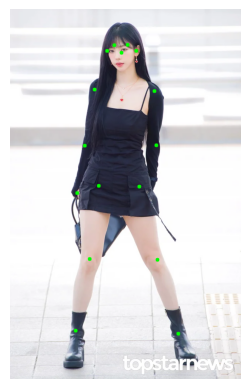

ÏÜåÏöîÏãúÍ∞Ñ: 0:00:00.465958


In [17]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

image_path = "./data/sample.jpg"

# üìå MoveNet Î™®Îç∏ Î°úÎìú
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
model = movenet.signatures["serving_default"]

# üìå Ïù¥ÎØ∏ÏßÄ Î°úÎìú
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

# ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Î≥µÏÇ¨
image_copy = image.copy()
h, w = image.shape[:2]

start = datetime.now()  ### ÏÜçÎèÑ ÌôïÏù∏ ###

# üìå 1. Ïù¥ÎØ∏ÏßÄ Î¶¨ÏÇ¨Ïù¥Ïßï (192x192) + Ìå®Îî© Í≥†Î†§
def resize_with_padding(image, target_size=192):
    h, w = image.shape[:2]
    scale = target_size / max(h, w)  # Í∞ÄÏû• Í∏¥ Î≥Ä Í∏∞Ï§Ä Ïä§ÏºÄÏùº Í≥ÑÏÇ∞
    new_w, new_h = int(w * scale), int(h * scale)
    resized_image = cv2.resize(image, (new_w, new_h))

    # Ìå®Îî© Ï∂îÍ∞Ä (Í∞ÄÎ°ú/ÏÑ∏Î°ú Ï§ë ÏßßÏùÄ Ï™Ω)
    pad_w = (target_size - new_w) // 2
    pad_h = (target_size - new_h) // 2
    
    padded_image = cv2.copyMakeBorder(
        resized_image, pad_h, target_size - new_h - pad_h, 
        pad_w, target_size - new_w - pad_w, 
        cv2.BORDER_CONSTANT, value=(255, 255, 255)
    )
    return padded_image, scale, pad_w, pad_h, new_w, new_h

padded_image, scale, pad_w, pad_h, new_w, new_h = resize_with_padding(image)

# MoveNet ÏûÖÎ†• ÌòïÏãù ÎßûÏ∂îÍ∏∞
input_image = np.expand_dims(padded_image, axis=0)
input_image = tf.convert_to_tensor(input_image, dtype=tf.int32)

# üìå 2. Î™®Îç∏ Ïã§Ìñâ
outputs = model(input_image)
keypoints_with_scores = outputs["output_0"].numpy()[0, 0, :, :]  # (17, 3)

# üìå 3. Ï¢åÌëú Î≥ÄÌôò Î∞è ÌïÑÌÑ∞ÎßÅ
threshold = 0.5  # Ïã†Î¢∞ÎèÑ Í∏∞Ï§Ä

# keypoints ÏàúÏÑú: (y, x, conf)
for i, (y, x, conf) in enumerate(keypoints_with_scores):
    if conf > threshold:
        # Ï†ïÍ∑úÌôîÎêú Ï¢åÌëú(0~1)Î•º Ìå®Îî© Í≥†Î†§ÌïòÏó¨ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î°ú Î≥ÄÌôò
        x_coord = int(((x * 192) - pad_w) / scale)  # Í∞ÄÎ°ú (width) Î≥ÄÌôò
        y_coord = int(((y * 192) - pad_h) / scale)  # ÏÑ∏Î°ú (height) Î≥ÄÌôò
        
        # Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Ï¢åÌëúÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ ÌõÑ ÌëúÏãú
        if 0 <= x_coord < w and 0 <= y_coord < h:
            cv2.circle(image_copy, (x_coord, y_coord), 5, (0, 255, 0), -1)

# üìå 4. ÏãúÍ∞ÅÌôîÎêú Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("ÏÜåÏöîÏãúÍ∞Ñ:", datetime.now() - start)  ### ÏÜçÎèÑ ÌôïÏù∏ ###


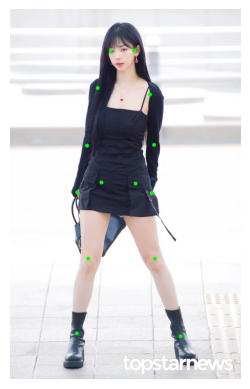

ÏÜåÏöîÏãúÍ∞Ñ: 0:00:00.444139


In [18]:
### Ìå®Îî© ÏïàÎÑ£Í≥† ÏßÑÌñâ

import tensorflow as tf
import tensorflow_hub as hub


# üìå MoveNet Î™®Îç∏ Î°úÎìú
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
model = movenet.signatures["serving_default"]

# üìå Ïù¥ÎØ∏ÏßÄ Î°úÎìú
image = cv2.imread(image_path)
if image is None:
    print(f"Error: Cannot load image from {image_path}")
    exit()

# ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Î≥µÏÇ¨ Î∞è ÌÅ¨Í∏∞ Ï†ïÎ≥¥ Ï†ÄÏû•
image_copy = image.copy()
orig_h, orig_w = image.shape[:2]

start = datetime.now()  ### ÏÜçÎèÑ ÌôïÏù∏ ###

# üìå 1. Ïù¥ÎØ∏ÏßÄ Î¶¨ÏÇ¨Ïù¥Ï¶à (Ìå®Îî© ÏóÜÏù¥ 192x192Î°ú Î≥ÄÌôò)
resized_image = cv2.resize(image, (192, 192))

# MoveNet ÏûÖÎ†• ÌòïÏãù ÎßûÏ∂îÍ∏∞
input_image = np.expand_dims(resized_image, axis=0)
input_image = tf.convert_to_tensor(input_image, dtype=tf.int32)

# üìå 2. Î™®Îç∏ Ïã§Ìñâ
outputs = model(input_image)
keypoints_with_scores = outputs["output_0"].numpy()[0, 0, :, :]  # (17, 3)

# üìå 3. Ï¢åÌëú Î≥ÄÌôò Î∞è ÌïÑÌÑ∞ÎßÅ
threshold = 0.5  # Ïã†Î¢∞ÎèÑ Í∏∞Ï§Ä

# keypoints ÏàúÏÑú: (y, x, score)
for i, (y, x, conf) in enumerate(keypoints_with_scores):
    if conf > threshold:
        # Ï†ïÍ∑úÌôîÎêú Ï¢åÌëú(0~1)Î•º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î°ú Î≥ÄÌôò
        x_coord = int(x * orig_w)
        y_coord = int(y * orig_h)
        
        # Ïù¥ÎØ∏ÏßÄ ÎÇ¥Ïóê Ï¢åÌëúÍ∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏ ÌõÑ ÌëúÏãú
        if 0 <= x_coord < orig_w and 0 <= y_coord < orig_h:
            cv2.circle(image_copy, (x_coord, y_coord), 5, (0, 255, 0), -1)

# üìå 4. ÏãúÍ∞ÅÌôîÎêú Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("ÏÜåÏöîÏãúÍ∞Ñ:", datetime.now() - start)  ### ÏÜçÎèÑ ÌôïÏù∏ ###


### HRNet - Î≥¥Î•ò
- C++ Ïª¥ÌååÏùºÎü¨ ÌïÑÏöî
- ÏùºÎã® Î≥¥Î•ò 

In [8]:
import torch
print(torch.version.cuda)


12.1


### ViTPose
- Bounding BoxÍ∞Ä ÏûàÏñ¥Ïïº ÏÇ¨ÎûåÏùò Ìè¨Ï¶àÎ•º Ï†ïÌôïÌûà Ïù∏Ïãù

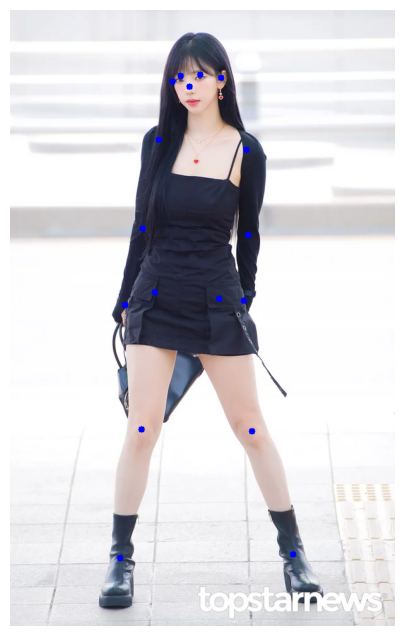

ÏÜåÏöîÏãúÍ∞Ñ: 0:00:00.358060


In [20]:
import torch
import requests
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

# üìå ÎîîÎ∞îÏù¥Ïä§ ÏÑ§Ï†ï (CUDA ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏)
device = "cuda" if torch.cuda.is_available() else "cpu"

# üìå Ïù¥ÎØ∏ÏßÄ Î°úÎìú (Í≤ΩÎ°ú ÏÑ§Ï†ï)
image_path = "./data/sample.jpg"  # Î°úÏª¨ ÌååÏùº ÏÇ¨Ïö©
image_pil = Image.open(image_path).convert("RGB")  # PIL ÌòïÏãùÏúºÎ°ú Î°úÎìú

# üìå OpenCVÎ•º ÏúÑÌïú Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò (PIL ‚Üí OpenCV)
image_cv = np.array(image_pil)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)  # OpenCVÎäî BGR ÏÇ¨Ïö©

# ------------------------------------------------------------------------
# **1Ô∏è‚É£ Stage 1: ÏÇ¨Îûå ÌÉêÏßÄ (RT-DETR)**
# ------------------------------------------------------------------------

# üìå Í∞ùÏ≤¥ ÌÉêÏßÄ Î™®Îç∏ Î°úÎìú
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)


# üìå Ìè¨Ï¶à Ï∂îÏ†ï Î™®Îç∏ Î°úÎìú
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base").to(device)

start = datetime.now()  ### ÏÜçÎèÑ ÌôïÏù∏ ###

# üìå Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨
inputs = person_image_processor(images=image_pil, return_tensors="pt").to(device)

# üìå Ï∂îÎ°† Ïã§Ìñâ
with torch.no_grad():
    outputs = person_model(**inputs)

# üìå Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image_pil.height, image_pil.width)]), threshold=0.3
)
result = results[0]  # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ Í≤∞Í≥º

# üìå COCO Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú 'ÏÇ¨Îûå' ÌÅ¥ÎûòÏä§Îäî index 0
person_boxes = result["boxes"][result["labels"] == 0]

# **Bounding Box Î≥ÄÌôò (VOC -> COCO)**
if person_boxes.shape[0] > 0:  # ÏÇ¨ÎûåÏù¥ Í≤ÄÏ∂úÎêú Í≤ΩÏö∞Îßå Ïã§Ìñâ
    person_boxes = person_boxes.cpu().numpy()
    person_boxes[:, 2] -= person_boxes[:, 0]
    person_boxes[:, 3] -= person_boxes[:, 1]

# ------------------------------------------------------------------------
# **2Ô∏è‚É£ Stage 2: Ìè¨Ï¶à Ï∂îÏ†ï (ViTPose)**
# ------------------------------------------------------------------------

# üìå ÏÇ¨ÎûåÏù¥ Í∞êÏßÄÎêú Í≤ΩÏö∞Îßå Ìè¨Ï¶à Ï∂îÏ†ï ÏàòÌñâ
if person_boxes.shape[0] > 0:
    inputs = pose_processor(images=image_pil, boxes=[person_boxes], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor([0], device=device)  # ViTPoseÏùò MOE Íµ¨Ï°∞ ÎåÄÏùë

    with torch.no_grad():
        outputs = pose_model(**inputs)

    # üìå Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨
    pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
    image_pose_result = pose_results[0]  # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ Í≤∞Í≥º
else:
    image_pose_result = []

# ------------------------------------------------------------------------
# **3Ô∏è‚É£ ÏãúÍ∞ÅÌôî (Keypoints ÌëúÏãú)**
# ------------------------------------------------------------------------

# üìå Keypoints Í∑∏Î¶¨Í∏∞
for person_pose in image_pose_result:
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        if score > 0.5:  # Ïã†Î¢∞ÎèÑ 50% Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞Îßå ÌëúÏãú
            x, y = map(int, keypoint)
            cv2.circle(image_cv, (x, y), 5, (255, 0, 0), -1)  # ÌååÎûÄÏÉâ Ï†ê

# üìå ÏãúÍ∞ÅÌôîÎêú Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("ÏÜåÏöîÏãúÍ∞Ñ:", datetime.now() - start)  ### ÏÜçÎèÑ ÌôïÏù∏ ###


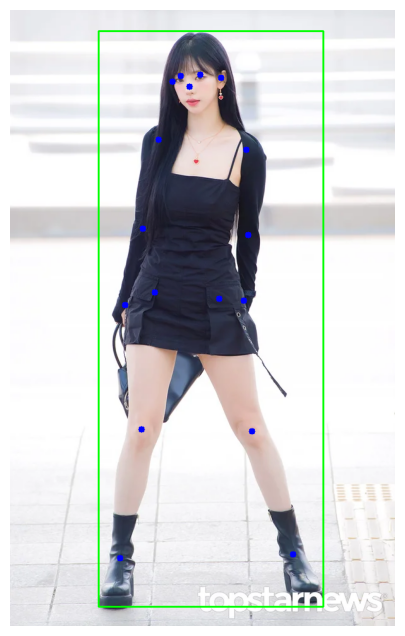

ÏÜåÏöîÏãúÍ∞Ñ: 0:00:00.338068


In [ ]:
import torch
import requests
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

# üìå ÎîîÎ∞îÏù¥Ïä§ ÏÑ§Ï†ï (CUDA ÏÇ¨Ïö© Í∞ÄÎä• Ïó¨Î∂Ä ÌôïÏù∏)
device = "cuda" if torch.cuda.is_available() else "cpu"

# üìå Ïù¥ÎØ∏ÏßÄ Î°úÎìú (Í≤ΩÎ°ú ÏÑ§Ï†ï)
image_path = "./data/sample.jpg"  # Î°úÏª¨ ÌååÏùº ÏÇ¨Ïö©
image_pil = Image.open(image_path).convert("RGB")  # PIL ÌòïÏãùÏúºÎ°ú Î°úÎìú

# üìå OpenCVÎ•º ÏúÑÌïú Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò (PIL ‚Üí OpenCV)
image_cv = np.array(image_pil)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)  # OpenCVÎäî BGR ÏÇ¨Ïö©

# ------------------------------------------------------------------------
# **1Ô∏è‚É£ Stage 1: ÏÇ¨Îûå(Bounding Box) ÌÉêÏßÄ (RT-DETR)**
# ------------------------------------------------------------------------

# üìå Í∞ùÏ≤¥ ÌÉêÏßÄ Î™®Îç∏ Î°úÎìú
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365").to(device)

# üìå Ìè¨Ï¶à Ï∂îÏ†ï Î™®Îç∏ Î°úÎìú
pose_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
pose_model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base").to(device)

start = datetime.now()  ### ÏÜçÎèÑ ÌôïÏù∏ ###

# üìå Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨
inputs = person_image_processor(images=image_pil, return_tensors="pt").to(device)

# üìå Ï∂îÎ°† Ïã§Ìñâ
with torch.no_grad():
    outputs = person_model(**inputs)

# üìå Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨
results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image_pil.height, image_pil.width)]), threshold=0.3
)
result = results[0]  # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ Í≤∞Í≥º

# üìå COCO Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú 'ÏÇ¨Îûå' ÌÅ¥ÎûòÏä§Îäî index 0
person_boxes = result["boxes"][result["labels"] == 0]

# **Bounding Box Î≥ÄÌôò (VOC -> COCO)**
# VOC ÌòïÏãù: (x1, y1, x2, y2) ‚Üí COCO ÌòïÏãù: (x, y, width, height)
if person_boxes.shape[0] > 0:  # ÏÇ¨ÎûåÏù¥ Í≤ÄÏ∂úÎêú Í≤ΩÏö∞Îßå Ïã§Ìñâ
    person_boxes = person_boxes.cpu().numpy()
    person_boxes[:, 2] -= person_boxes[:, 0]
    person_boxes[:, 3] -= person_boxes[:, 1]

# ------------------------------------------------------------------------
# **2Ô∏è‚É£ Stage 2: Ìè¨Ï¶à Ï∂îÏ†ï (ViTPose)**
# ------------------------------------------------------------------------


# üìå ÏÇ¨ÎûåÏù¥ Í∞êÏßÄÎêú Í≤ΩÏö∞Îßå Ìè¨Ï¶à Ï∂îÏ†ï ÏàòÌñâ
if person_boxes.shape[0] > 0:
    inputs = pose_processor(images=image_pil, boxes=[person_boxes], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor([0], device=device)  # ViTPoseÏùò MOE Íµ¨Ï°∞ ÎåÄÏùë

    with torch.no_grad():
        outputs = pose_model(**inputs)

    # üìå Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨
    pose_results = pose_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.3)
    image_pose_result = pose_results[0]  # Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ Í≤∞Í≥º
else:
    image_pose_result = []

# ------------------------------------------------------------------------
# **3Ô∏è‚É£ ÏãúÍ∞ÅÌôî (Bounding Box Î∞è Keypoints ÌëúÏãú)**
# ------------------------------------------------------------------------

# üìå Bounding Box Í∑∏Î¶¨Í∏∞
for box in person_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_cv, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Ï¥àÎ°ùÏÉâ Î∞ïÏä§

# üìå Keypoints Í∑∏Î¶¨Í∏∞
for person_pose in image_pose_result:
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        if score > 0.5:  # Ïã†Î¢∞ÎèÑ 50% Ïù¥ÏÉÅÏù∏ Í≤ΩÏö∞Îßå ÌëúÏãú
            x, y = map(int, keypoint)
            cv2.circle(image_cv, (x, y), 5, (255, 0, 0), -1)  # ÌååÎûÄÏÉâ Ï†ê

# üìå ÏãúÍ∞ÅÌôîÎêú Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print("ÏÜåÏöîÏãúÍ∞Ñ:", datetime.now() - start)  ### ÏÜçÎèÑ ÌôïÏù∏ ###